# Weighting

As described earlier, there may be cases in which the output lag distributions from pyPetal contain false peaks and are affected by aliasing. We've already discussed how the detrending module within pyPetal functions. Now, we focus on the weighting module, which is a more in-depth method of finding the true peak within lag distributions.

We follow the procedure described in (CITATION of Grier et al. (2019)), which has shown to work on a sample of AGN used in reverberation mapping projects.

## Obtaining the Weights

Firstly, we introduce a weighting scheme based on the number of overlapping data points at a given time lag $\tau$. We expect that a true time lag $\tau$ would be more likely if there are more overlapping points between two light curves after shifting one light curve with respect to the other by $\tau$. 

This number of overlapping points $N(\tau)$ also takes into account the seasonal gaps with the unmoved lught curve - when moved by $\tau$, if a data point falls into a seasonal gap within the unmoved data, it will not count toward the total number of points for that lag.

We then create a weighting distribution by dividing by $N(0)$ (the number of overlapping points at $\tau=0$), and raising to a certain exponential $k$. In (Grier 2017 CITATION) and (Grier 2019 CITATION), $k=2$ is used, though the user may specify a number that works best for their analysis.

pyPetal can get this distribution $P(\tau) = [N(\tau) / N(0)]^k$ for us. We'll use the RM017 light curve data again:

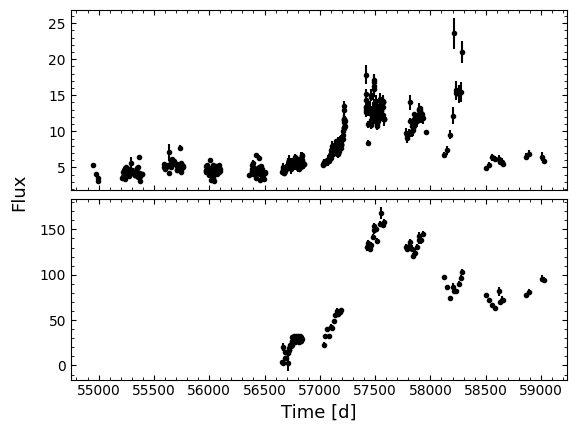

In [3]:
import numpy as np
import matplotlib.pyplot as plt

main_dir = 'pypetal/examples/dat/rm017_'
x1, y1, yerr1 = np.loadtxt(main_dir + 'cont.txt', unpack=True, usecols=[0,1,2])
x2, y2, yerr2 = np.loadtxt( main_dir + 'hb.txt', unpack=True, usecols=[0,1,2,])

fig, ax = plt.subplots( 2, 1, sharex=True )

ax[0].errorbar(x1, y1, yerr1, fmt='.k')
ax[1].errorbar(x2, y2, yerr2, fmt='.k')

ax[1].set_xlabel('Time [d]', fontsize=13)
plt.figtext(.03, .5, 'Flux', rotation=90, va='center', fontsize=13 )

plt.subplots_adjust( hspace=.05 )
plt.show()

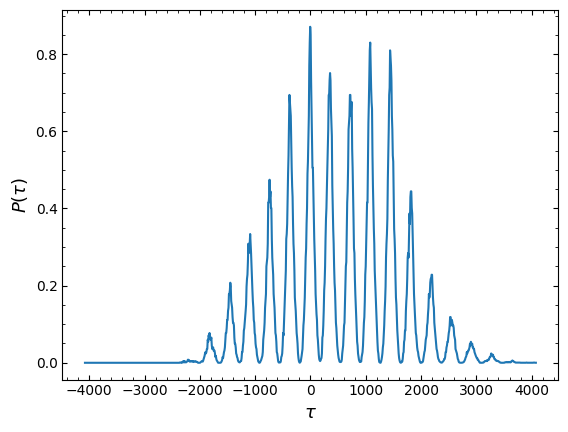

In [2]:
from pypetal.weighting import prob_tau

ptau, ntau, n0, lags = prob_tau(x1, x2, Nlag=1000, gap_size=30, k=2)

plt.plot(lags, ptau)
plt.ylabel(r'$P(\tau)$', fontsize=13)
plt.xlabel(r'$\tau$', fontsize=13)
plt.show()

To augment this weighting scheme, we'll follow (Grier 2019 CITATION) and convolve $P(\tau)$ with the autocorrelation function (ACF) of the continuum light curve, which gives us the final weight distribution $w(\tau)$.

.. note:: When convolving, we set all negative points in the ACF to 0.

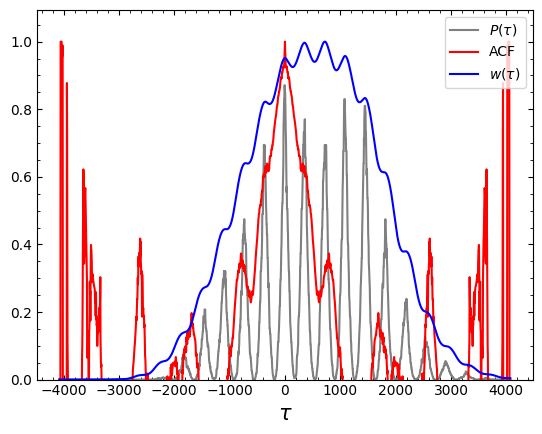

In [4]:
from pypetal.weighting import get_weights

weights, lags, ntau, acf, n0 = get_weights(x1, y1, x2, y2, gap_size=30, k=2)

plt.plot( lags, (ntau/n0)**2, c='gray', label=r'$P(\tau)$' )
plt.plot( lags, acf, c='r', label='ACF' )
plt.plot( lags, weights, c='b', label=r'$w(\tau)$' )

plt.ylim(bottom=0)
plt.xlabel(r'$\tau$', fontsize=15)

plt.legend()
plt.show()

After obtaining the lag distribution, we can then use $w(\tau)$ to find the true peak of the distribution. 

In addition to using the weights, we'll also smooth with a Gaussian distribution after applying the weights. This helps to find peaks in the distribution instead of large spikes in the data. (Grier 2019 CITATION) use a Gaussian with a width of 15 days, though this can be input by the user.

After isolating the primary peak with the smoothed distribution, we'll downsample the original distribution to only contain samples within the primary peak. We'll then use this dowsnampled distribution to perform all future analysis.

## Weighting in pyPetal

Now, we can use the weight distribution to weight the lag distributions output from pyPetal.

pyPetal can weight output lag distributions from two of the modules: the CCCD from pyCCF and the lag distribution from JAVELIN.

If the weighting module is run, it will detect which module (pyCCF and/or JAVELIN) was used, and weight their output distributions.

The weighting module takes the following input arguments:

* ``gap_size``: The minimum gap size to use to detect gaps in the continuum light curve when obtaining $N(\tau)$.
* ``k``: The exponent used when calculating $P(\tau)$
* ``width``: The width of the Gaussian used to smooth the weighted distribution to find the primary peak.
* ``zoom``: Whether tozoom in on the peak with an inset in the output plot.

## Using the Weighting Module

We'll perform an example of run of pyPetal using both pyCCF and JAVELIN. To run the weighting module, we'll set ``run_weighting=True``:

In [5]:
import pypetal.pipeline as pl

main_dir = 'pypetal/examples/dat/javelin_'
filenames = [ main_dir + 'continuum.dat', main_dir + 'yelm.dat' ]

output_dir = 'weighting_output/'
line_names = ['continuum', 'line1']


Running pyCCF
-----------------
lag_bounds: [[-1976.98849, 1976.98849]]
interp: 2.0000000001
nsim: 2000
mcmode: 0
sigmode: 0.2
thres: 0.8
nbin: 50
-----------------
        
Failed centroids:  0
Failed peaks:  0


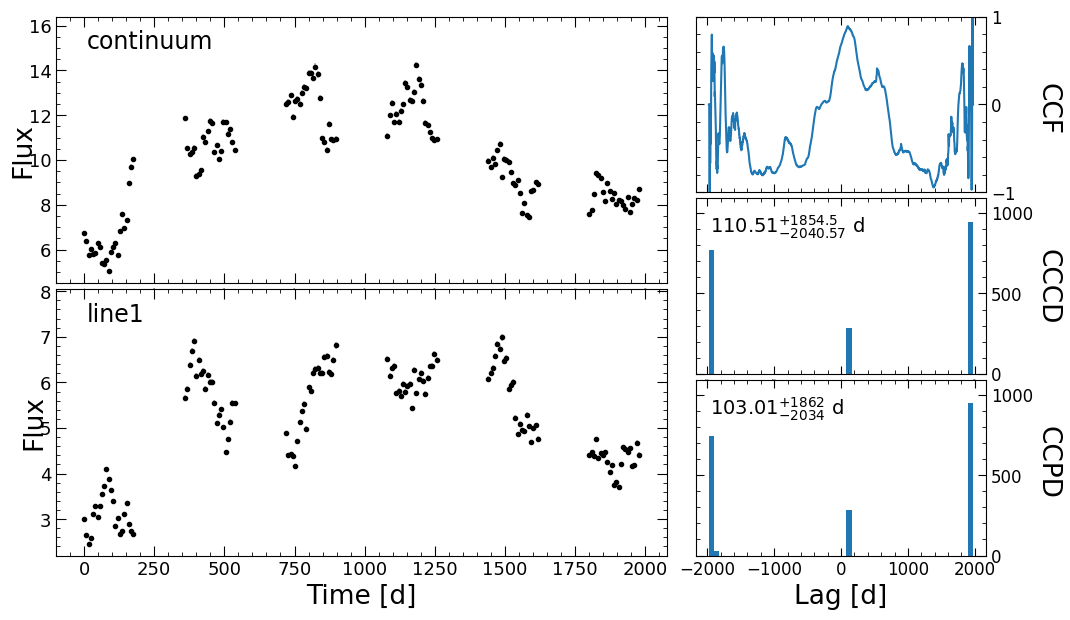


Running JAVELIN
--------------------
rm_type: spec
lagtobaseline: 0.3
laglimit: [[-1976.98849, 1976.98849]]
fixed: True
p_fix: True
subtract_mean: True
nwalker: 50
nburn: 50
nchain: 100
output_chains: True
output_burn: True
output_logp: True
nbin: 50
metric: med
together: False
--------------------
        
start burn-in
nburn: 50 nwalkers: 50 --> number of burn-in iterations: 2500
burn-in finished
save burn-in chains to /home/stone28/projects/petl_mock/test_repo/weighting_output/line1/javelin/burn_cont.txt
start sampling
sampling finished
acceptance fractions for all walkers are
0.69 0.61 0.77 0.71 0.69 0.77 0.64 0.73 0.69 0.66 0.72 0.77 0.74 0.72 0.76 0.67 0.78 0.71 0.65 0.80 0.70 0.67 0.76 0.67 0.61 0.63 0.67 0.74 0.72 0.75 0.70 0.69 0.67 0.82 0.77 0.75 0.73 0.66 0.74 0.85 0.69 0.74 0.73 0.82 0.82 0.71 0.77 0.68 0.71 0.71
save MCMC chains to /home/stone28/projects/petl_mock/test_repo/weighting_output/line1/javelin/chain_cont.txt
save logp of MCMC chains to /home/stone28/projects/pe

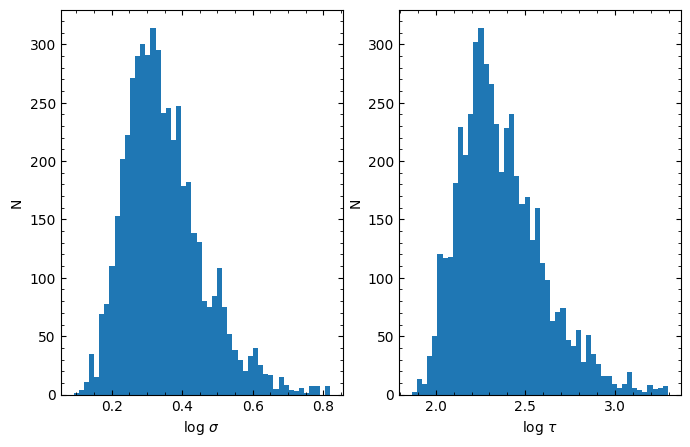

run single chain without subdividing matrix 
start burn-in
using priors on sigma and tau from continuum fitting
[[  1.758 139.728]
 [  2.135 211.769]
 [  2.817 385.38 ]]
penalize lags longer than 0.30 of the baseline
no penalizing long widths, but within the baseline
nburn: 50 nwalkers: 50 --> number of burn-in iterations: 2500
burn-in finished
save burn-in chains to /home/stone28/projects/petl_mock/test_repo/weighting_output/line1/javelin/burn_rmap.txt
start sampling
sampling finished
acceptance fractions are
0.08 0.00 0.01 0.04 0.03 0.03 0.01 0.03 0.07 0.07 0.05 0.09 0.07 0.10 0.08 0.06 0.12 0.14 0.12 0.00 0.10 0.13 0.02 0.03 0.06 0.10 0.02 0.09 0.09 0.11 0.04 0.08 0.07 0.02 0.12 0.06 0.03 0.05 0.08 0.03 0.06 0.04 0.07 0.03 0.10 0.06 0.13 0.05 0.05 0.12
save MCMC chains to /home/stone28/projects/petl_mock/test_repo/weighting_output/line1/javelin/chain_rmap.txt
save logp of MCMC chains to /home/stone28/projects/petl_mock/test_repo/weighting_output/line1/javelin/logp_rmap.txt
HPD of si

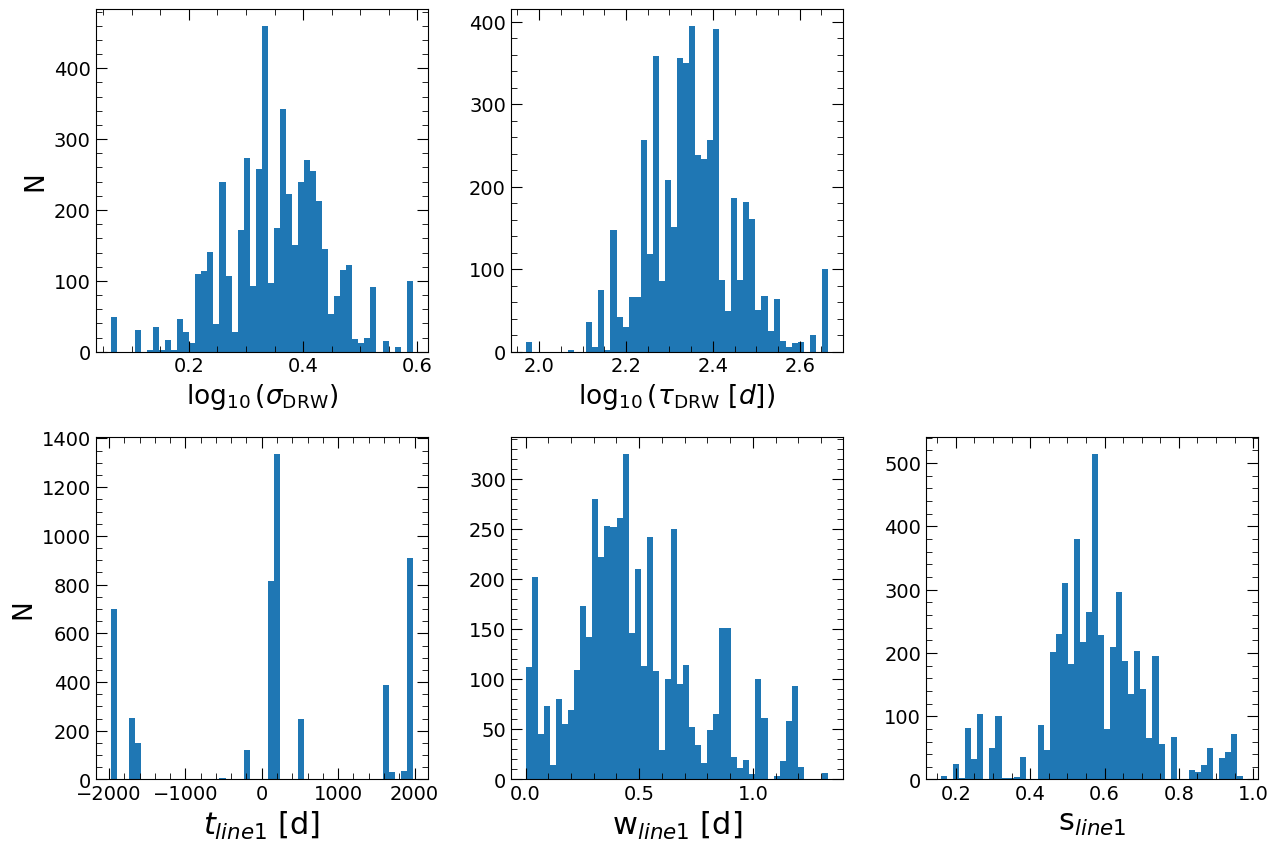

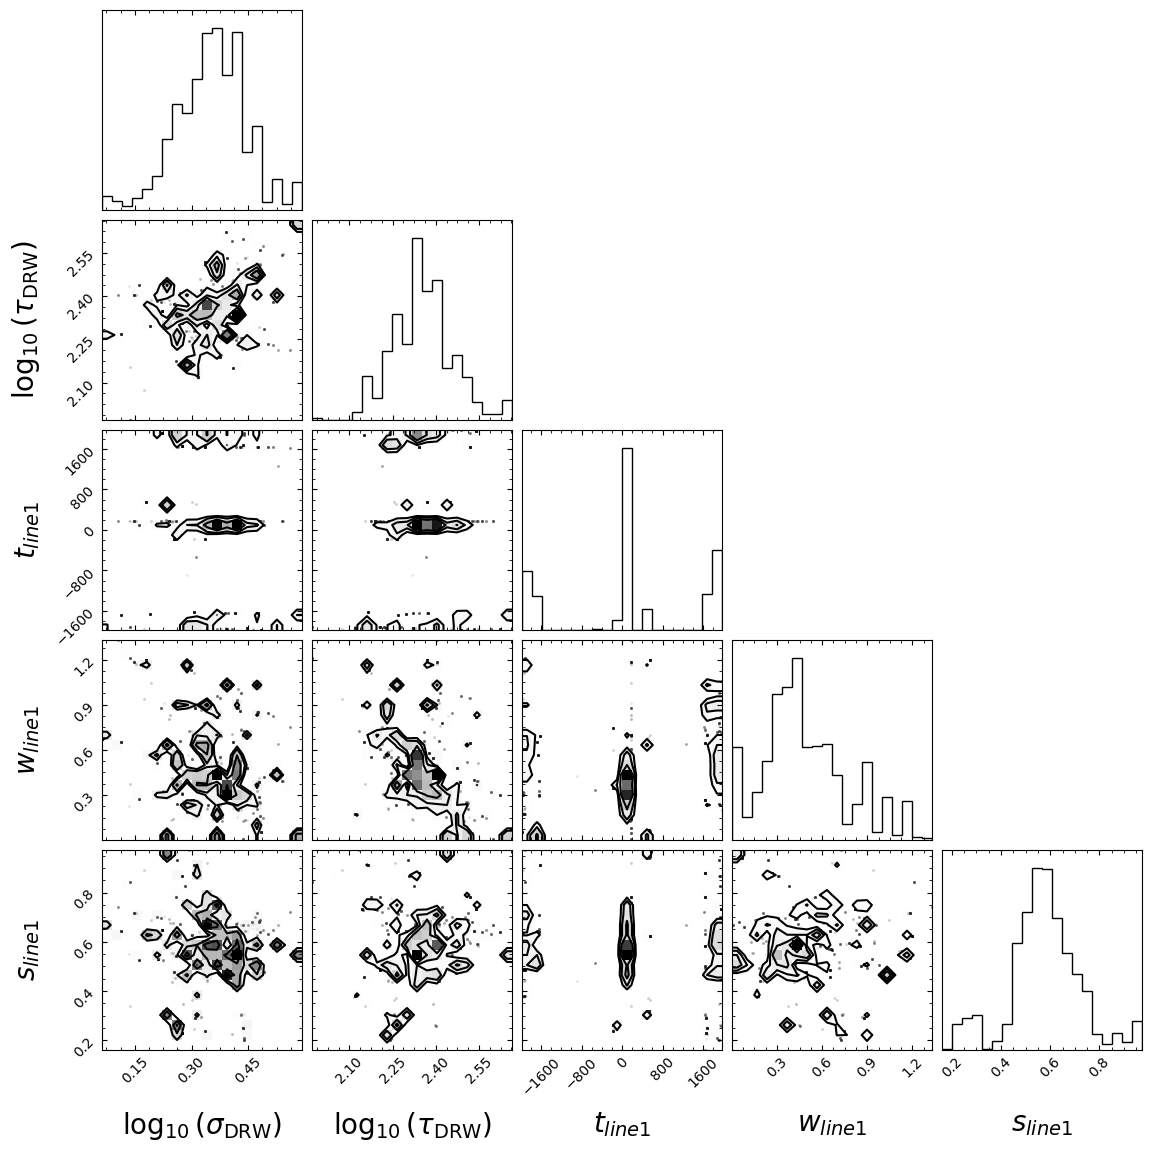

covariance matrix calculated
covariance matrix decomposed and updated by U


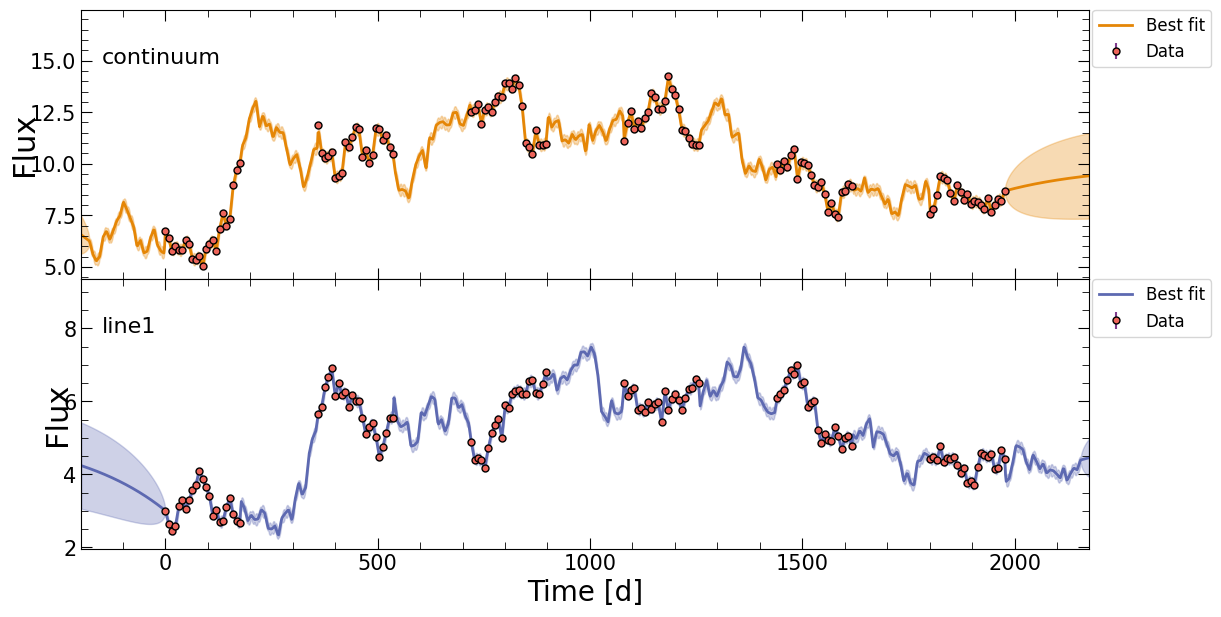

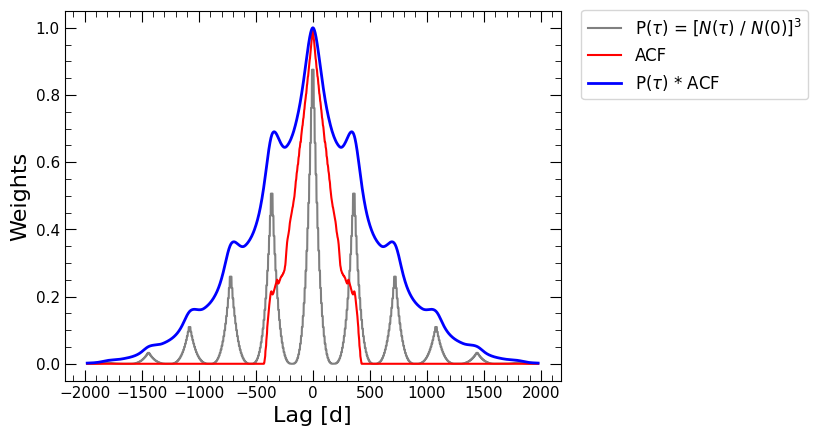

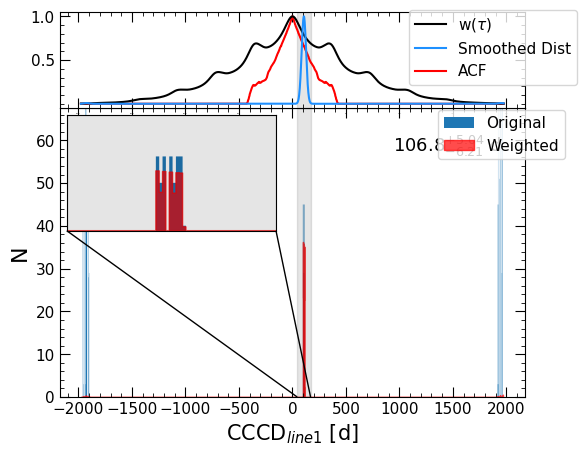

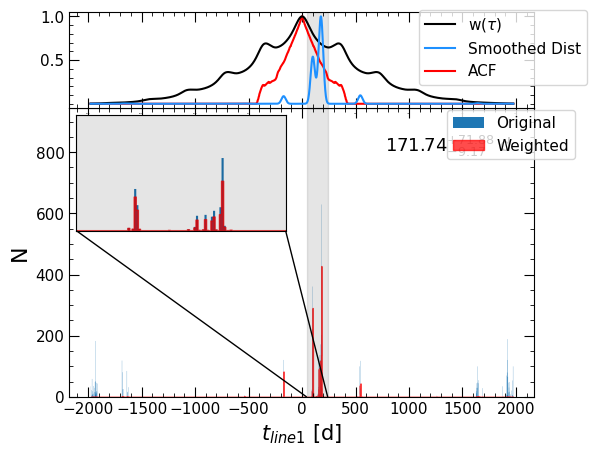

In [6]:
pyccf_params = {
    'nsim': 2000
}

javelin_params = {
    'nwalker': 50,
    'nburn': 50,
    'nchain': 100,
}

weighting_params = {
    'k': 3,
    'width': 20
}

res = pl.run_pipeline( output_dir, filenames, line_names,
                 run_pyccf=True, pyccf_params=pyccf_params,
                 run_javelin=True, javelin_params=javelin_params,
                 run_weighting=True, weighting_params=weighting_params,
                 verbose=True,
                 plot=True,
                 file_fmt='ascii',
                 threads=45)

We can see that pyPetal ouptput a nuber of plots from the pyCCF and JAVELIN modules that we have seen before, as well as diagnostic plots from the weighting process. 

The first plot is similar to the plot made at the beginning of this notebook, showing $w(\tau)$, $P(\tau)$, and the ACF of the continuum. 

The next two plots show the weighted distributions of the CCCD and the time lag from JAVELIN $t$. The top panel shows the ACF of the continuum, the weight distribution $w(\tau)$, and the weighted lag distributions that have been smoothed with a Gaussian. The bounds of the detected primary peak are shaded in gray.

The bottom panel shows the original distribution in blue and the weighted distribution (without smoothing) in red. Since ``zoom=True`` in the weighting arguments, an inset is produced in the plot zooming in on the primary peak. 

We can see that the weighting helped identify the actual peak in the CCCD, whereas the original CCCD had false peaks at the edges of the distribution. 

.. note:: If we had only run pyCCF or JAVELIN, there would be only one output plot, for either the CCCD or JAVELIN lag.

## Output Files

The weighting module has a number of outputs, for both of the modules that were run. Each line will have a directory ``weights/`` with a number of outputs from the module:

* ``javelin_weighted_lag_dist.dat``: The downsampled lag distribution.
* ``javelin_weights.dat``: Contains a number of weighting distributions for the JAVELIN lag distribution
  * $N(\tau)$
  * $w(\tau)$
  * the ACF of the continuum
  * the smoothed $P(\tau)$ ("smooth_dist")
  * the smoothed $w(\tau)$ ("smoothweight_dist") 
  * the lags they were computed on
* ``pyccf_weighted_cccd.dat``: The downsampled CCCD.
* ``pyccf_weights.dat``: Contains the same information as ``javelin_weights.dat``, but for the CCCD.
* ``weight_summary``: A text file containing various quantities from both the CCCD and JAVELIN lag weighting
  * ``k``: The exponent used to calculate $P(\tau)$
  * ``n0``: $N(0)$
  * ``peak_bounds``: The bounds of the primary peak, given as [lower bound, upper bound]
  * ``peak``: The peak of the primary peak
  * ``lag_value``: The median of the downsampled lag distribution
  * ``lag uncertainty``: The uncertainty on the lag, given as [lower error, upper error]
  * ``fraction rejected``: The fraction of the original distribution that was rejected to obtain the downsampled distribution.
  * ``rmax``: The maximum value of the CCCD within the region covered by the downsampled JAVELIN lag distribution.

Each line will also have a figure to show the weighting distribution ($P(\tau)$, the ACF, $w(\tau)$) in the ``weights/`` directory, labeled ``(name)_weights.pdf``.

The main directory ``output_dir`` will also contain one figure for each module (pyCCF and/or JAVELIN), showing the detected lag and the weighted+original distributions (as shown above with the inset plot), labeled ``pyccf_weights_res`` and ``javelin_weights_res.pdf``. These two plots will contain subplots for each line.

## Output Dict

All results from the weighting module will be under the ``weighting res`` key of the overall pyPetal output. This will be another dictionary, with one key for each module (``pyccf`` and ``javelin``), as well as a key for ``rmax``.

The ``pyccf`` dictionary will contain the following keys, which are arrays, with values for each line:

* ``centroid``: The median of the downsampled CCCD and its uncertainties, given as [lower error, value, upper error]
* ``bounds``: The bounds and lag value of the primary peak, given as [lower bound, peak, upper bound]
* ``acf``: The ACF of the continuum
* ``lags``: The lags that the weighting distributions are computed on
* ``weight_dist``: The weight distribution $w(\tau)$
* ``smooth_dist``: The smoothed $w(\tau)$
* ``ntau``: The number of overlapping points at a given lag $N(\tau)$
* ``downsampled_CCCD``: The downsampled CCCD
* ``frac_rejected``: The fraction of the original CCCD rejected when downsampling


The ``javelin`` dictionary will contain the following keys, which are arrays, with values for each line:

* ``tophat_lag``: The median of the JAVELIN lag and its uncertainties, given as [lower error, value, upper error]
* ``bounds``: The bounds and lag value of the primary peak, given as [lower bound, peak, upper bound]
* ``acf``: The ACF of the continuum
* ``lags``: The lags that the weighting distributions are computed on
* ``weight_dist``: The weight distribution $w(\tau)$
* ``smooth_dist``: The smoothed $w(\tau)$
* ``ntau``: The number of overlapping points at a given lag $N(\tau)$
* ``downsampled_lag_dist``: The downsampled JAVELIN lag distribution
* ``frac_rejected``: The fraction of the original JAVELIN lag distribution rejected when downsampling


In [7]:
res['weighting_res']['pyccf'].keys()

dict_keys(['centroid', 'bounds', 'acf', 'lags', 'weight_dist', 'smoothed_dist', 'ntau', 'CCCD', 'downsampled_CCCD', 'frac_rejected'])

In [8]:
res['weighting_res']['rmax']

[1.000000000000012]